In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
#!unzip -q ~/data/salt_keras/train.zip -d ~/data/salt_keras/train
#!unzip -q ~/data/salt_keras/test.zip -d ~/data/salt_keras/test


In [51]:
# Set some parameters
im_width = 64
im_height = 64
border = 5
#path_train = '/home/labis/data/salt_keras/train/'
path_train = '/home/labis/eclipse-workspace/Utilities/'
path_test = '/home/labis/eclipse-workspace/Utilities/'

In [52]:
from tqdm import tqdm


# Get and resize train images and masks
def get_data(path, train=True):
    ids = next(os.walk(path + "images"))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/images/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (im_width, im_height, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path + '/labels/' + id_, grayscale=True))
            mask = resize(mask, (im_width, im_height, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)

100%|██████████| 4/4 [00:00<00:00, 287.70it/s]

Getting and resizing images ... 
Done!


In [53]:
print(X.shape)

(4, 64, 64, 1)


In [54]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2020)
print(X_train.shape)

(3, 64, 64, 1)


Text(0.5, 1.0, 'Salt')

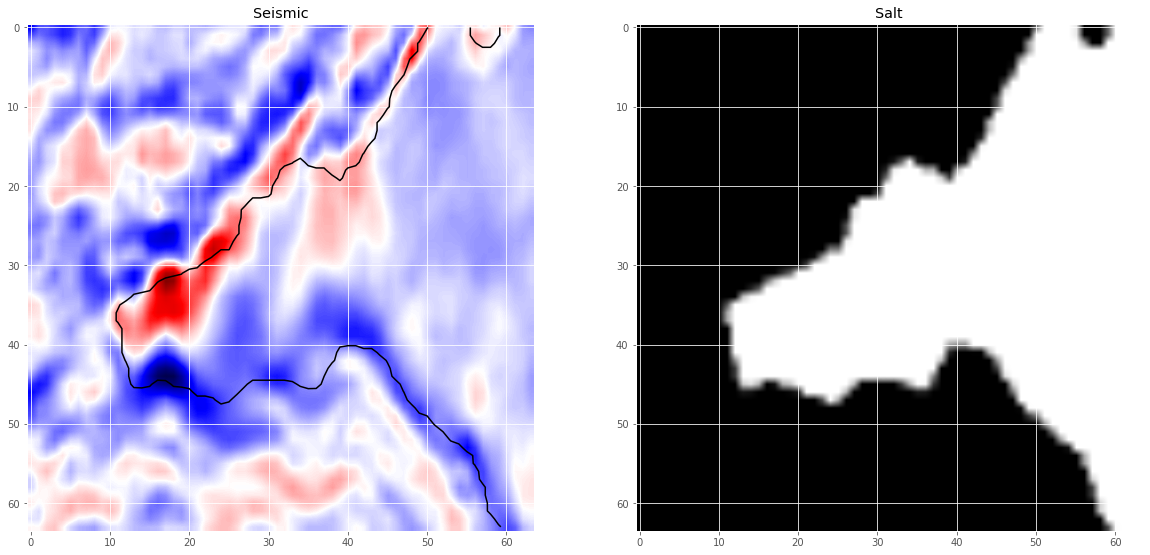

In [55]:
ix = random.randint(0,len(X_train)-1) ### -1 needed...
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1,2,figsize=(20,10))

ax[0].imshow(X_train[ix,...,0], cmap='seismic', interpolation = 'bilinear')

if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')


ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt')

In [85]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = False):
    
    x = Conv2D(filters = n_filters, kernel_size =(kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = n_filters, kernel_size =(kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [86]:
def get_unet(input_img,n_filters = 16, dropout = 0.5, batchnorm = False):
    #Encoder part
    c1 = conv2d_block(input_img,n_filters=n_filters,kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D(2,2)(c1)
    #p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)


    p2 = MaxPooling2D((2, 2)) (c2)
    #p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    #p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    #p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    #Decoder part
    
    u6 = Conv2DTranspose(n_filters*8, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    #u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    #u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    #u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    #u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model
    

In [87]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0, batchnorm=False)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()



Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_117 (Conv2D)             (None, 64, 64, 16)   160         img[0][0]                        
__________________________________________________________________________________________________
activation_109 (Activation)     (None, 64, 64, 16)   0           conv2d_117[0][0]                 
__________________________________________________________________________________________________
conv2d_118 (Conv2D)             (None, 64, 64, 16)   2320        activation_109[0][0]             
____________________________________________________________________________________________

In [88]:
results = model.fit(X_train, y_train, batch_size=2, epochs=300)

Epoch 1/300
3/3 [==============================] - 1s 428ms/step - loss: 0.7530 - accuracy: 0.4736
Epoch 2/300
3/3 [==============================] - 0s 58ms/step - loss: 0.7214 - accuracy: 0.5388
Epoch 3/300
3/3 [==============================] - 0s 59ms/step - loss: 0.6907 - accuracy: 0.5352
Epoch 4/300
3/3 [==============================] - 0s 59ms/step - loss: 0.6882 - accuracy: 0.5422
Epoch 5/300
3/3 [==============================] - 0s 60ms/step - loss: 0.6868 - accuracy: 0.5514
Epoch 6/300
3/3 [==============================] - 0s 58ms/step - loss: 0.6853 - accuracy: 0.5644
Epoch 7/300
3/3 [==============================] - 0s 59ms/step - loss: 0.6832 - accuracy: 0.5737
Epoch 8/300
3/3 [==============================] - 0s 62ms/step - loss: 0.6812 - accuracy: 0.5806
Epoch 9/300
3/3 [==============================] - 0s 61ms/step - loss: 0.6764 - accuracy: 0.6035
Epoch 10/300
3/3 [==============================] - 0s 58ms/step - loss: 0.6750 - accuracy: 0.6339
Epoch 11/300
3/3 [

3/3 [==============================] - 0s 69ms/step - loss: 0.0167 - accuracy: 0.9753
Epoch 84/300
3/3 [==============================] - 0s 58ms/step - loss: 0.0155 - accuracy: 0.9754
Epoch 85/300
3/3 [==============================] - 0s 70ms/step - loss: 0.0152 - accuracy: 0.9757
Epoch 86/300
3/3 [==============================] - 0s 68ms/step - loss: 0.0150 - accuracy: 0.9757
Epoch 87/300
3/3 [==============================] - 0s 54ms/step - loss: 0.0145 - accuracy: 0.9757
Epoch 88/300
3/3 [==============================] - 0s 54ms/step - loss: 0.0138 - accuracy: 0.9757
Epoch 89/300
3/3 [==============================] - 0s 57ms/step - loss: 0.0144 - accuracy: 0.9757
Epoch 90/300
3/3 [==============================] - 0s 59ms/step - loss: 0.0137 - accuracy: 0.9757
Epoch 91/300
3/3 [==============================] - 0s 54ms/step - loss: 0.0136 - accuracy: 0.9757
Epoch 92/300
3/3 [==============================] - 0s 55ms/step - loss: 0.0133 - accuracy: 0.9756
Epoch 93/300
3/3 [=====

3/3 [==============================] - 0s 61ms/step - loss: 0.0103 - accuracy: 0.9758
Epoch 166/300
3/3 [==============================] - 0s 57ms/step - loss: 0.0102 - accuracy: 0.9758
Epoch 167/300
3/3 [==============================] - 0s 54ms/step - loss: 0.0102 - accuracy: 0.9758
Epoch 168/300
3/3 [==============================] - 0s 55ms/step - loss: 0.0102 - accuracy: 0.9758
Epoch 169/300
3/3 [==============================] - 0s 55ms/step - loss: 0.0102 - accuracy: 0.9758
Epoch 170/300
3/3 [==============================] - 0s 55ms/step - loss: 0.0101 - accuracy: 0.9758
Epoch 171/300
3/3 [==============================] - 0s 56ms/step - loss: 0.0101 - accuracy: 0.9758
Epoch 172/300
3/3 [==============================] - 0s 56ms/step - loss: 0.0100 - accuracy: 0.9758
Epoch 173/300
3/3 [==============================] - 0s 54ms/step - loss: 0.0101 - accuracy: 0.9758
Epoch 174/300
3/3 [==============================] - 0s 55ms/step - loss: 0.0100 - accuracy: 0.9758
Epoch 175/300


3/3 [==============================] - 0s 57ms/step - loss: 0.0166 - accuracy: 0.9756
Epoch 248/300
3/3 [==============================] - 0s 58ms/step - loss: 0.0158 - accuracy: 0.9757
Epoch 249/300
3/3 [==============================] - 0s 61ms/step - loss: 0.0149 - accuracy: 0.9756
Epoch 250/300
3/3 [==============================] - 0s 58ms/step - loss: 0.0148 - accuracy: 0.9754
Epoch 251/300
3/3 [==============================] - 0s 55ms/step - loss: 0.0131 - accuracy: 0.9758
Epoch 252/300
3/3 [==============================] - 0s 55ms/step - loss: 0.0128 - accuracy: 0.9758
Epoch 253/300
3/3 [==============================] - 0s 58ms/step - loss: 0.0147 - accuracy: 0.9747
Epoch 254/300
3/3 [==============================] - 0s 64ms/step - loss: 0.0120 - accuracy: 0.9758
Epoch 255/300
3/3 [==============================] - 0s 58ms/step - loss: 0.0119 - accuracy: 0.9758
Epoch 256/300
3/3 [==============================] - 0s 57ms/step - loss: 0.0126 - accuracy: 0.9757
Epoch 257/300


KeyError: 'val_loss'

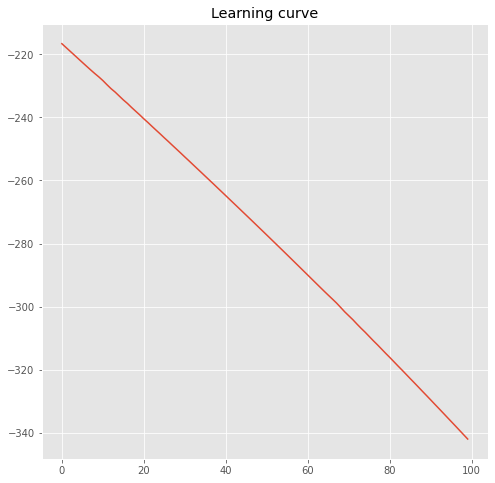

In [102]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

In [89]:
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 0s 103ms/step


[3.239691734313965, 0.717529296875]

In [90]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 19ms/step


In [91]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary')

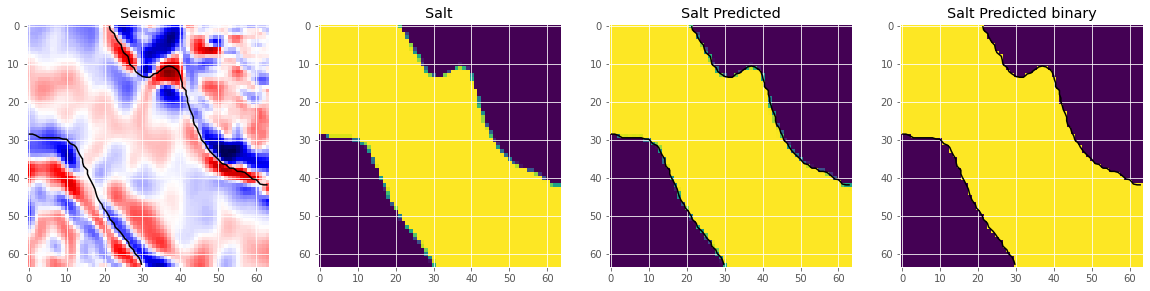

In [96]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=0)

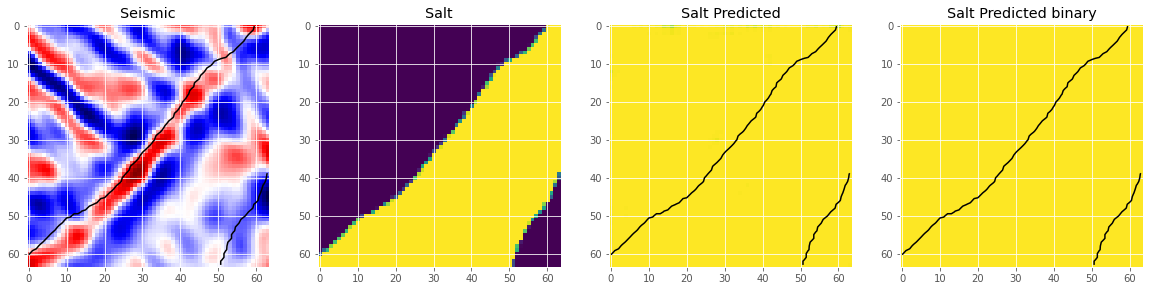

In [18]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=0)

In [97]:
model.save_weights("/home/labis/eclipse-workspace/Utilities/Keras_Weights.h5")

In [80]:
model.load_weights("/home/labis/eclipse-workspace/Utilities/Keras_Weights.h5")